In [7]:
pip install pandas seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [60]:
ls /home/aiscuser/RecAI/RecLM-emb/data/xbox/test

gpt_misspell.jsonl       misspell2item.jsonl   relativequery2item.jsonl
gpt_query.jsonl          negquery2item.jsonl   sparse_query2item.jsonl
gpt_summary.jsonl        query2item.jsonl      title2item.jsonl
gpt_summary_query.jsonl  queryuser2item.jsonl  user2item.jsonl
item2item.jsonl          qwen72B/


In [78]:
import os
import json
import pandas as pd

# 定义根目录
root_dir = "output/xbox_infer"

# 用于存储整理后的数据
data = []



# 遍历根目录下的所有文件夹
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    
    # 检查是否是文件夹
    if os.path.isdir(folder_path):
        # 定位all_metrics.jsonl文件
        metrics_file = os.path.join(folder_path, "all_metrics.jsonl")
        
        # 读取jsonl文件
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                # 将metrics按模型和任务类型进行存储
                for line in f:
                    metric_data = json.loads(line)
                    model = folder  # 以文件夹名称作为模型名称
                    task_name = metric_data.get("task_name", "unknown_task")
                    metrics = metric_data.get("metrics", {})
                    for metric_name, metric_value in metrics.items():
                        if metric_name =="ndcg@5":
                            data.append([model, task_name, metric_name, metric_value])
                        if task_name in ["query2item", "sparse_query2item"]
                            if metric_name =="coverage@5":
                                data.append([model, task_name, metric_name, metric_value])


# 创建DataFrame
df = pd.DataFrame(data, columns=["model", "task", "metric", "value"])

# 保存为CSV文件
output_csv_path = "output/all_models_metrics_filtered.csv"
df.to_csv(output_csv_path, index=False)

# 打印生成的DataFrame
print(df)


               model                task  metric     value
0        bge-m3-base           user2item  ndcg@5  0.010694
1        bge-m3-base          title2item  ndcg@5  0.992249
2        bge-m3-base           item2item  ndcg@5  0.063210
3        bge-m3-base      queryuser2item  ndcg@5  0.246815
4        bge-m3-base       misspell2item  ndcg@5  0.820900
5        bge-m3-base        gpt_misspell  ndcg@5  0.961519
6        bge-m3-base         gpt_summary  ndcg@5  0.004076
7        bge-m3-base   gpt_summary_query  ndcg@5  0.050494
8        bge-m3-base           gpt_query  ndcg@5  0.237188
9        bge-m3-base  relativequery2item  ndcg@5  0.005570
10       bge-m3-base       negquery2item  ndcg@5  0.458925
11  e5-large-v2_1007           user2item  ndcg@5  0.113755
12  e5-large-v2_1007          title2item  ndcg@5  0.977135
13  e5-large-v2_1007           item2item  ndcg@5  0.737143
14  e5-large-v2_1007      queryuser2item  ndcg@5  0.845974
15  e5-large-v2_1007       misspell2item  ndcg@5  0.6499

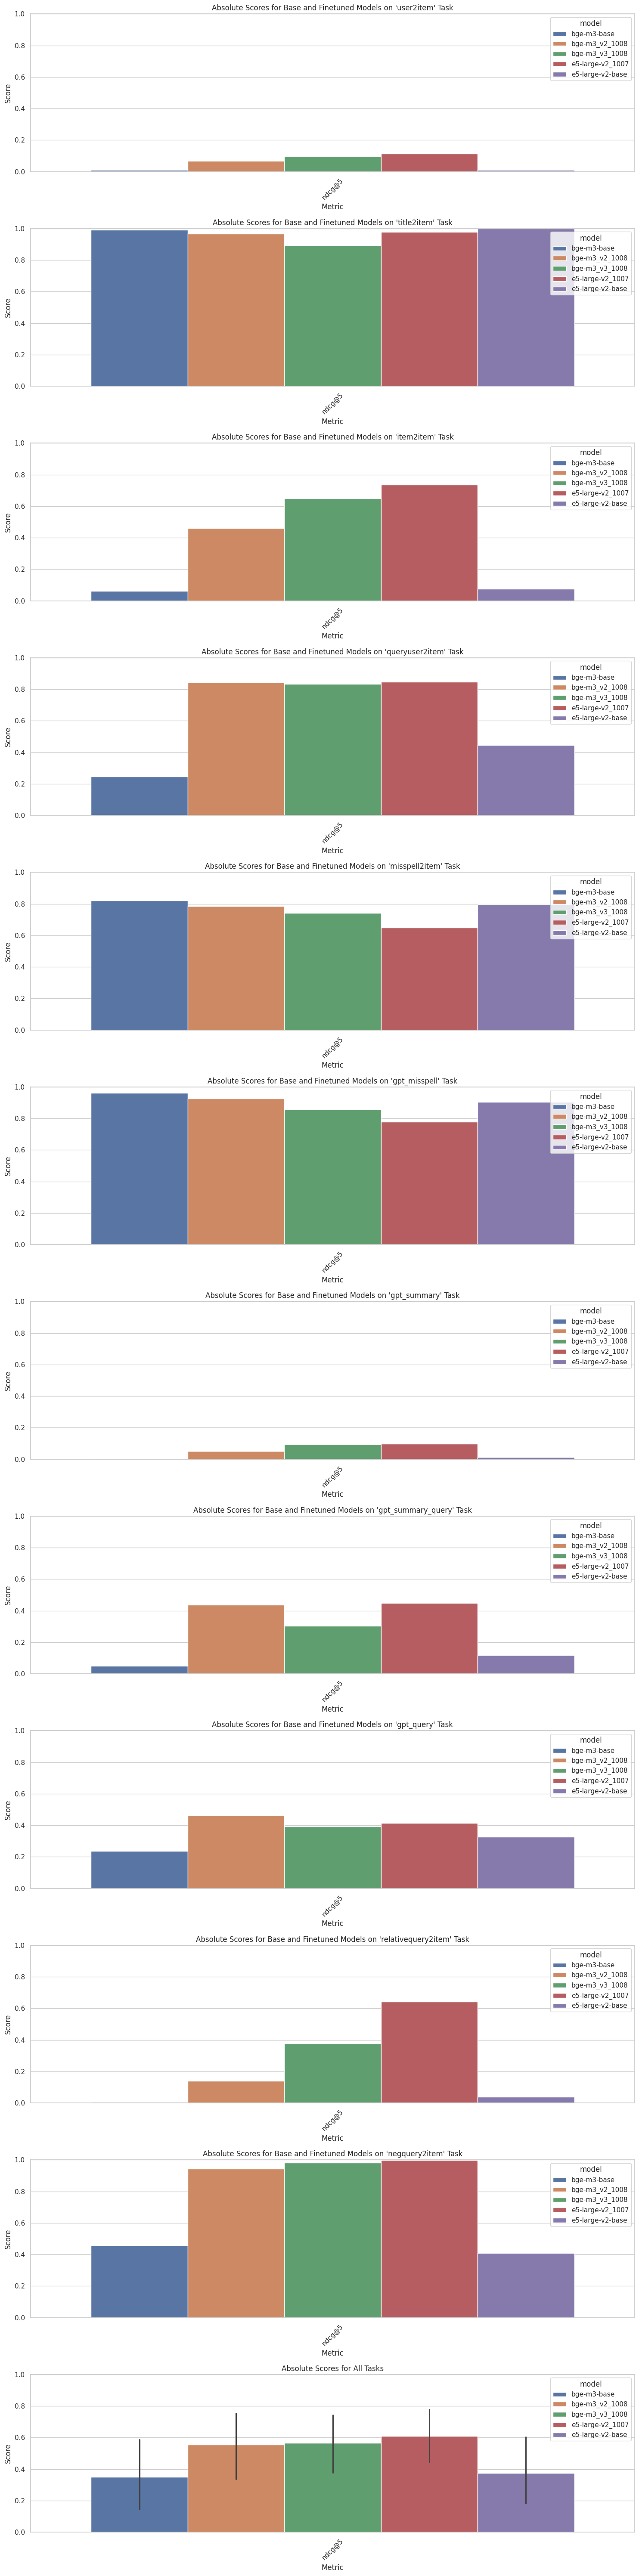

All images have been saved to ./metric_images


In [70]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

file_path = "./metric_images/summary.png"  # 替换为你想要保存图片的目录路径


# 假设 base 模型以 '-base' 为标志，例如 'bge-m3-base' 或 'e5-large-v2-base'
base_model_suffix = '-base'

# 初始化一个空的 DataFrame 来保存数据
plot_data = []

# 遍历每个唯一的任务
for task in df["task"].unique().tolist():
    # 过滤当前任务的数据
    task_data = df[df["task"] == task]
    
    # 匹配 'bge' 和 'e5' 模型的前缀，并包括 '-base' 后缀的模型
    model_names = task_data["model"].str.extract(r'(bge-m3|e5-large-v2).*')[0].dropna().unique()

    for model_prefix in model_names:
        # 获取该模型的 base 和 finetuned 数据
        selected_rows = task_data[task_data["model"].str.contains(f"{model_prefix}")]
        
        # 对每个 metric 处理绝对分值
        for metric in task_data["metric"].unique():
            for _, row in selected_rows.iterrows():
                if row["metric"] == metric:
                    # 记录模型及其绝对分值
                    plot_data.append([task, model_prefix, row["model"], metric, row["value"]])

# 将数据转换为 DataFrame
plot_df = pd.DataFrame(plot_data, columns=["task", "model_prefix", "model", "metric", "value"])

# 设置 Seaborn 的样式
sns.set(style="whitegrid")

# 获取所有任务的列表
tasks = plot_df["task"].unique().tolist()

# 创建一个大图用于包含所有子图
fig, axes = plt.subplots(nrows=len(tasks) + 1, ncols=1, figsize=(15, 5 * (len(tasks) + 1)))

# 遍历每个唯一的任务，绘制绝对分值的子图
for idx, task in enumerate(tasks):
    # 过滤当前任务的数据
    task_data = plot_df[plot_df["task"] == task]

    # 绘制绝对分值的条形图到子图中
    sns.barplot(ax=axes[idx], x="metric", y="value", hue="model", data=task_data)

    # 设置图表标题和标签
    axes[idx].set_title(f"Absolute Scores for Base and Finetuned Models on '{task}' Task")
    axes[idx].set_xlabel("Metric")
    axes[idx].set_ylabel("Score")

    # 根据不同的 metric 调整刻度范围（例如覆盖范围 0 到 1，准确率等可设置在 0-1 的范围）
    axes[idx].set_ylim(0, 1)  # 默认设置在 0-1 之间

    # 调整 x 轴标签的字体大小和旋转角度
    axes[idx].tick_params(axis='x', rotation=45)

# 绘制包含所有任务的综合表现的子图
sns.barplot(ax=axes[-1], x="metric", y="value", hue="model", data=plot_df)
axes[-1].set_title("Absolute Scores for All Tasks")
axes[-1].set_xlabel("Metric")
axes[-1].set_ylabel("Score")
axes[-1].set_ylim(0, 1)
axes[-1].tick_params(axis='x', rotation=45)

# 调整子图之间的间距
plt.tight_layout()

# 保存图片到文件
plt.savefig(file_path)
plt.show()
plt.close()
print(f"All images have been saved to {output_dir}")

In [79]:
import os
import json
import pandas as pd

root_dir = "/home/aiscuser/RecAI/RecLM-emb/data/xbox"
tasks_count = []

# 遍历 train 和 test 目录，读取每个任务的 jsonl 文件条数
for subfolder in ["train", "test"]:
    subfolder_path = os.path.join(root_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for jsonl_file in os.listdir(subfolder_path):
            if jsonl_file.endswith(".jsonl"):
                file_path = os.path.join(subfolder_path, jsonl_file)
                with open(file_path, 'r') as f:
                    line_count = sum(1 for line in f)
                tasks_count.append([subfolder, jsonl_file.replace(".jsonl", ""), line_count])

# 将任务计数数据转换为 DataFrame
tasks_df = pd.DataFrame(tasks_count, columns=["subset", "task", "line_count"])
df = pd.read_csv("/home/aiscuser/RecAI/RecLM-emb/output/all_models_metrics_filtered.csv")

merged_df = pd.merge(df, tasks_df, how="left", on="task")

# 输出到 CSV 文件
output_csv_path = "output/merged_models_metrics.csv"
merged_df.to_csv(output_csv_path, index=False)

# 展示前几行数据
merged_df.head()


,model,task,metric,value,subset,line_count
0,bge-m3-base,user2item,ndcg@5,0.010694,train,55422
1,bge-m3-base,user2item,ndcg@5,0.010694,test,50000
2,bge-m3-base,title2item,ndcg@5,0.992249,train,150
3,bge-m3-base,title2item,ndcg@5,0.992249,test,384
4,bge-m3-base,item2item,ndcg@5,0.063210,train,848


In [80]:

# 使用pivot_table将数据转换为所需格式
pivot_df = merged_df.pivot_table(index='task', columns='subset', values='line_count', aggfunc='sum').reset_index()
pivot_df.rename(columns={'train': 'train_count', 'test': 'test_count'}, inplace=True)

# 遍历唯一的模型名称，创建每个模型的评分列
models = df['model'].unique()
for model in models:
    model_scores = df[df['model'] == model][['task', 'metric', 'value']].drop_duplicates()
    model_scores = model_scores.pivot(index='task', columns='metric', values='value').reset_index()
    model_scores.columns = ['task'] + [f"{model}_{metric}" for metric in model_scores.columns if metric != 'task']
    
    # 将评分数据合并到主表中
    pivot_df = pd.merge(pivot_df, model_scores, on='task', how='left')

# 保存为CSV文件
output_csv_path = "output/processed_metrics_summary.csv"
pivot_df.to_csv(output_csv_path, index=False)